In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from astropy.io.votable import parse
from astropy.io.votable import parse_single_table
from astropy.io import fits
from astropy import wcs
from matplotlib.colors import LogNorm
from astropy.coordinates import Angle
from astropy import units as ut
import xml.etree.ElementTree as ET
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Circle
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic_2d
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, LSR,HeliocentricMeanEcliptic
from matplotlib.gridspec import GridSpec
from astropy.convolution import Gaussian1DKernel, convolve
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.integrate import trapz
import Gaussian_fitting as Gf
from scipy.ndimage import zoom
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from astropy.visualization.wcsaxes import SphericalCircle
import scipy as sp
from imp import reload
import glob

In [4]:
import sys,os
import Gaussian_fitting as Gf
#sys.path.append('../Absorption_fitting')
import spectra_decomposing as sd
import read_GASKAP_data as rd

In [5]:
datapathbase='/d/bip5/hchen'

# Gaussian_fitting

BIC  1270.277900980274 n=1
BIC  85.3774924639989 n= 2
BIC  84.49212162419553 n= 3
final n= 2


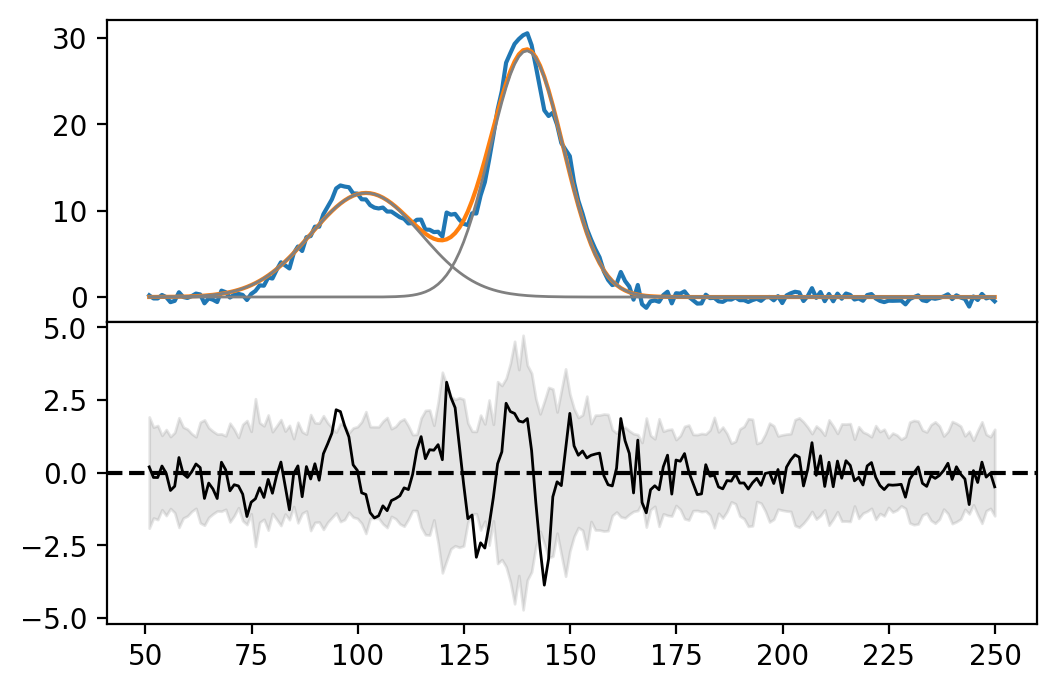

In [6]:

reload(Gf)
a=parse('/d/bip5/hchen/SMC/GASKAP-HI_Pilot_Survey/spectra/J003037-742901_spec.vot')
spectra_abs=a.get_first_table().to_table(use_names_over_ids=True)
x=np.array(spectra_abs['velocity']/1000)
y=np.array(spectra_abs['opacity'])
yerr=np.array(spectra_abs['sigma_opacity'])
yemi=np.array(spectra_abs['em_mean'])
yemi_err=np.array(spectra_abs['em_std'])
p=np.argwhere((x>50)&(x<250)).flatten()
#plt.plot(x[p],yemi[p])
Gf.fitting_plot(x[p],yemi[p],yemi_err[p])

0.9999999999999999 2
0.9933120051943195 3
0.9999995125563601 4
0.06623722403620382 5


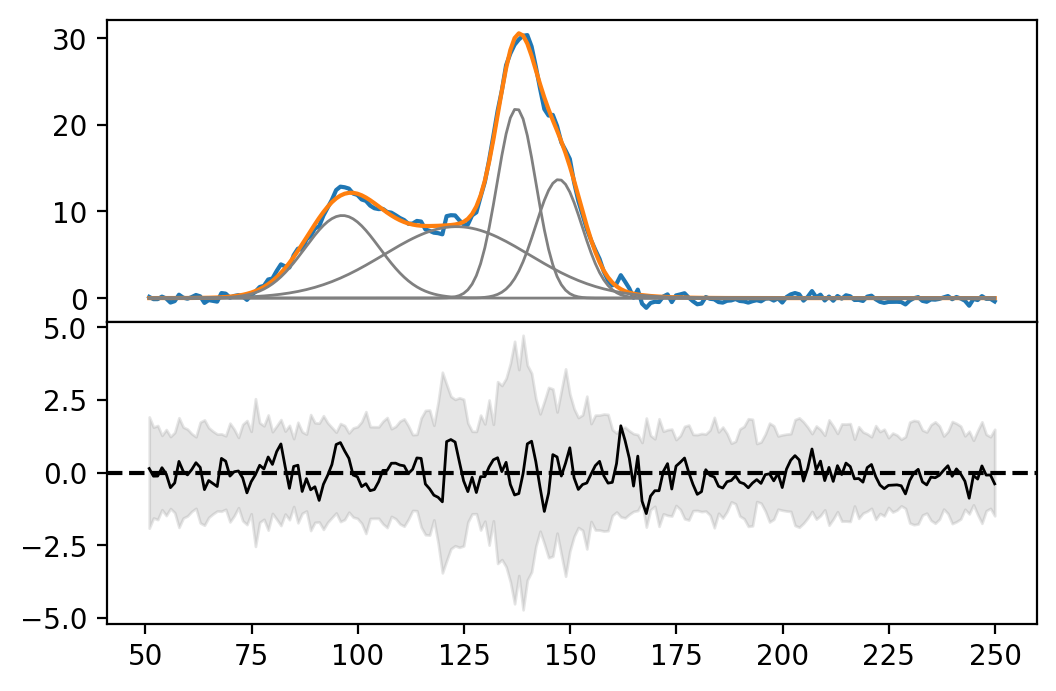

In [6]:
reload(Gf)
a=parse('/d/bip5/hchen/SMC/GASKAP-HI_Pilot_Survey/spectra/J003037-742901_spec.vot')
spectra_abs=a.get_first_table().to_table(use_names_over_ids=True)
x=np.array(spectra_abs['velocity']/1000)
y=np.array(spectra_abs['opacity'])
yerr=np.array(spectra_abs['sigma_opacity'])
yemi=np.array(spectra_abs['em_mean'])
yemi_err=np.array(spectra_abs['em_std'])
p=np.argwhere((x>50)&(x<250)).flatten()
#plt.plot(x[p],yemi[p])
Gf.fitting_plot(x[p],yemi[p],yemi_err[p],fit_mode='F_test')

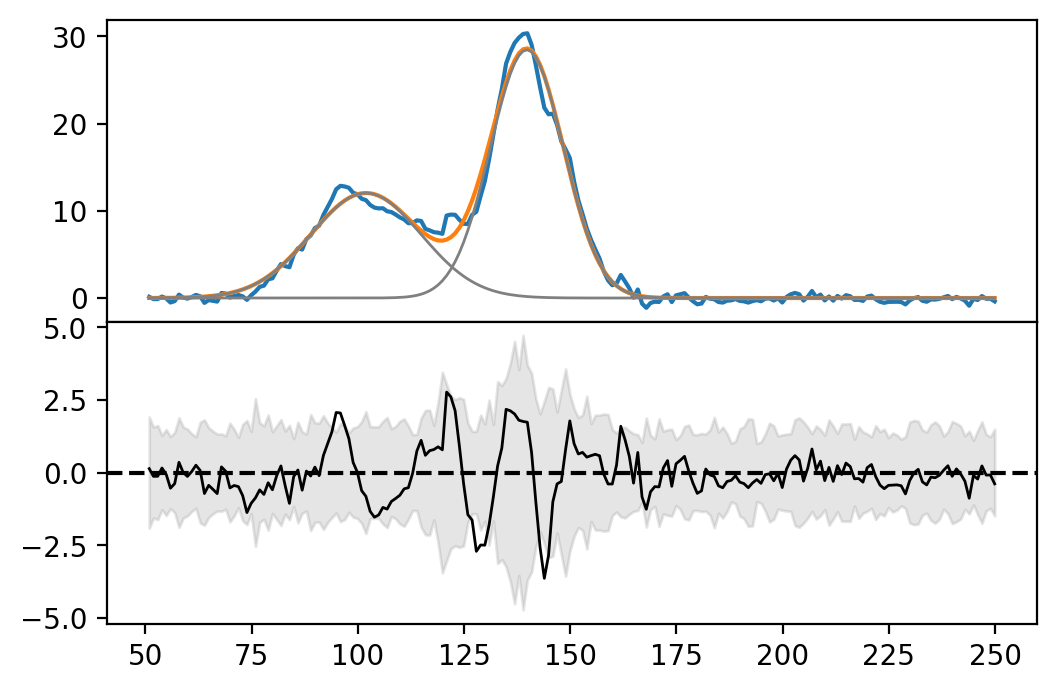

In [7]:
reload(Gf)
a=parse('/d/bip5/hchen/SMC/GASKAP-HI_Pilot_Survey/spectra/J003037-742901_spec.vot')
spectra_abs=a.get_first_table().to_table(use_names_over_ids=True)
x=np.array(spectra_abs['velocity']/1000)
y=np.array(spectra_abs['opacity'])
yerr=np.array(spectra_abs['sigma_opacity'])
yemi=np.array(spectra_abs['em_mean'])
yemi_err=np.array(spectra_abs['em_std'])
p=np.argwhere((x>50)&(x<250)).flatten()
#plt.plot(x[p],yemi[p])
Gf.fitting_plot(x[p],yemi[p],yemi_err[p],x_peak=[150,100])

# spectra_decomposing

In [6]:
#print sources observed twice
nemi=np.sort(glob.glob(datapathbase+'/LMC_GASKAP_emi_all_abs/*.txt'))
nabs_n=glob.glob(datapathbase+'/LMC_abs_new/sb*')
nabs=[None] * len(nemi)
for i, ni in enumerate(nemi):
    na_=ni[-18:-4]
    for nj in nabs_n:
        _=glob.glob(nj+'/spectra_abs/*')
        _all=[filename[-23:-9] for filename in _]
        if na_ in _all:
            if nabs[i] is not None:
                print(i,nj,na_)
                break  # Exit the loop once a match is found for this `na_`
            else:
                nabs[i] = f'{nj}/spectra_abs/{na_}_spec.vot'  # Record `nj` only once for this `na_`
                
nemi,nabs=np.array(nemi),np.array(nabs)  
nlist=[filename[-18:-4] for filename in nemi]
              

25 /d/bip5/hchen/LMC_abs_new/sb38814 J045207-665520
48 /d/bip5/hchen/LMC_abs_new/sb33047 J050200-693158
54 /d/bip5/hchen/LMC_abs_new/sb38814 J050411-670107
57 /d/bip5/hchen/LMC_abs_new/sb38791 J050500-664520
58 /d/bip5/hchen/LMC_abs_new/sb38791 J050501-664516
61 /d/bip5/hchen/LMC_abs_new/sb38814 J050529-665556
62 /d/bip5/hchen/LMC_abs_new/sb38791 J050531-655515
64 /d/bip5/hchen/LMC_abs_new/sb38814 J050543-665813
69 /d/bip5/hchen/LMC_abs_new/sb38791 J050831-670609
80 /d/bip5/hchen/LMC_abs_new/sb38814 J050946-670557
85 /d/bip5/hchen/LMC_abs_new/sb38791 J051222-673218
96 /d/bip5/hchen/LMC_abs_new/sb38791 J051537-672127
98 /d/bip5/hchen/LMC_abs_new/sb38845 J051641-714905
113 /d/bip5/hchen/LMC_abs_new/sb38845 J052415-715800
138 /d/bip5/hchen/LMC_abs_new/sb38845 J053254-723155


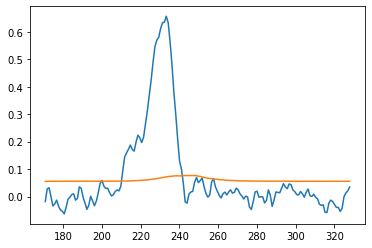

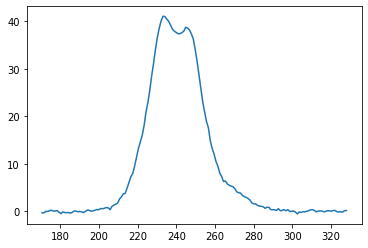

In [7]:
reload(rd)
j=22
x,y,yerr,xemi,yemi,yemi_err,yemi_selferr=rd.get_emi_abs_data(nlist[j],nabs[j],1,1,mode='LMC',v_move=0.)
plt.plot(x,1-np.exp(-y))
plt.plot(x,yerr*3)
plt.figure()
plt.plot(xemi,yemi)

In [29]:
-np.log(1-0.05389469409362386)*3

0.16620419729931477

[[(1.0, 246.0, 1.0), (1.0, 254.0, 1.0)], [(1.0, 240.0, 1.0), (1.0, 248.0, 1.0)]]
BIC= 433.5386317840398
[  0.71944443 249.37429771   2.30064033   0.33526688 243.03792165
   1.16572353]


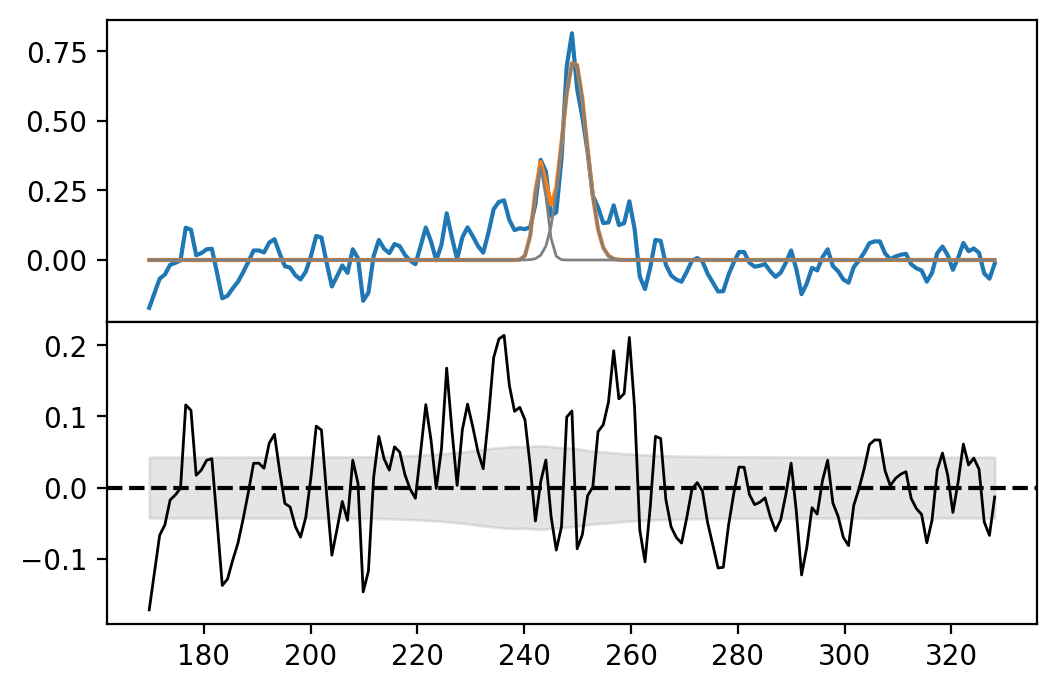

In [ ]:
reload(rd)
j=19
x,y,yerr,xemi,yemi,yemi_err,yemi_selferr=rd.get_emi_abs_data(nlist[j],nabs[j],1,1,mode='LMC',v_move=0.)
reload(Gf)
#Gf.fitting_plot(x,y,yerr,x_peak=[2.49390685e+02,2.44425563e+02])
Gf.fitting_plot(x,y,yerr,x_peak=[249,244])

BIC  377.56540653584057 n=1
BIC  330.7038933853921 n= 2
BIC  351.88591724022723 n= 3
final n= 2
popt_ori [  0.7194443  249.37429155   2.30064247   0.33526466 243.03788551
   1.16573581]
Ts_low limit [4.956476284841746, 4.129150815993736]
origin BIC  6211.701438136861 Original_Mean_score  6212.949191213511
BIC  134.48120982289294 Mean_score  134.52276447557338
BIC  111.73440782348179 Mean_score  113.45149358173074
BIC  74.69957694369879 Mean_score  77.67266831020699
BIC  84.42423534411384 Mean_score  87.70547513349445
Ts>3.77 (54,)
Ts>3.77 (54,)
final BIC  84.69957694369879
74.69957694369879
velocity shift [1.2403419 4.       ]



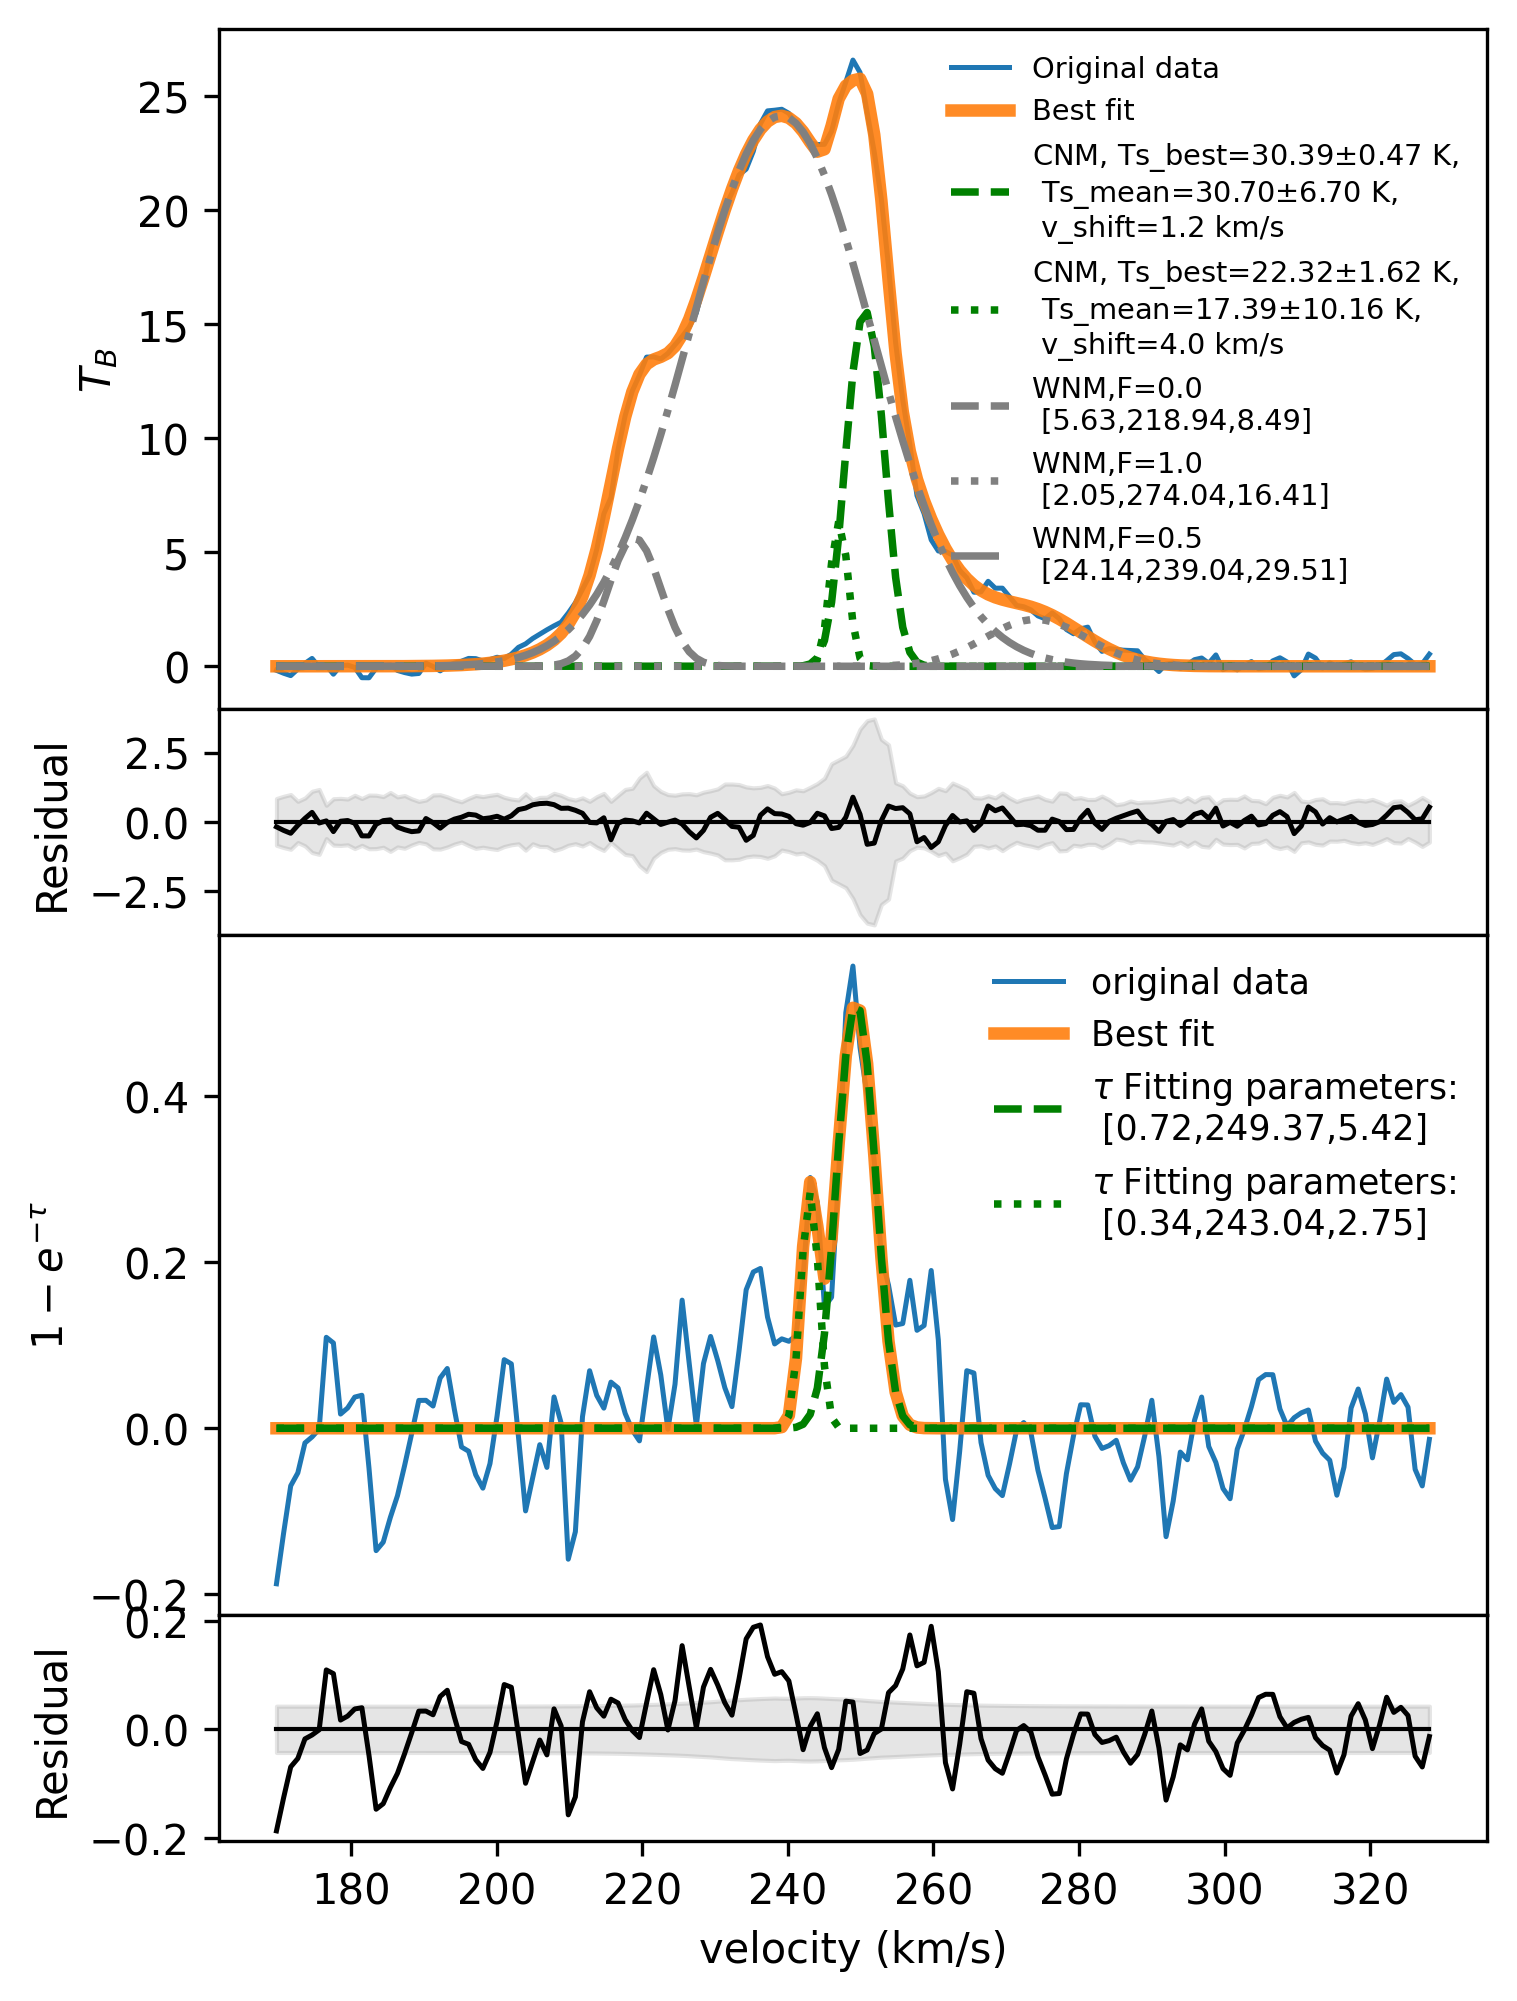

In [50]:
reload(sd)
reload(Gf)
reload(rd)
j=19
x,y,yerr,xemi,yemi,yemi_err,yemi_selferr=rd.get_emi_abs_data(nlist[j],nabs[j],1,1,mode='LMC',v_move=0.)

fig = plt.figure(figsize=(12, 8), dpi=300)

ax1_first = plt.subplot2grid((8, 2), (0, 0), rowspan=3, fig=fig)

ax = [ax1_first,
       plt.subplot2grid((8, 2), (3, 0), rowspan=1, fig=fig, sharex=ax1_first),
       plt.subplot2grid((8, 2), (4, 0), rowspan=3, fig=fig, sharex=ax1_first),
       plt.subplot2grid((8, 2), (7, 0), fig=fig, sharex=ax1_first)]

sd.fit_and_plot(x,y,yerr,xemi,yemi,yemi_err,ax,name=nlist[j],savetxt=False,
                peak_abs=[],peak_emi=[],Tsmin=3.77,
                 fit_mode='BIC',v_sh=4)

fig.savefig(datapathbase+'/output_data/LMC_fitting/plots/%s.png'%(nlist[j]), dpi=300, bbox_inches='tight') 

In [ ]:
reload(rap)
print(len(good_index))
peakemi=[[80,156],[80,156],[110,110,150,170],[],[],[],[],[],[],[],[],[],[],[],[]]
peakabs=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
iteration_max=[10,10,10,3,2]
#peakabs=[[240,248],[],[],[230,235],[230,235],[230,235],[230,235],[],[],[],[],[],]
plt.close('all')

# Step 2: Reset Matplotlib configuration to default
plt.rcdefaults()

fig = plt.figure(figsize=(15, 28),dpi=500)
m,n=4,3
subfigs = fig.subfigures(m, n, wspace=0,hspace=0)
#fig.subplots_adjust(hspace=0, wspace=0) 
p=5
for i in range(m):
    for j in range(n):
        ax_=subfigs[i,j].subplots(4, 1, sharex=True,gridspec_kw={'height_ratios': [3, 1,3,1]})
        
        if p==6:
            ind=good_index_SMC[p]
            rap.decomposing_CNM_WNM(p+1,name_low_SMC[ind],Ra_low_SMC[ind],Dec_low_SMC[ind],
                                    ax_,mode='SMC', 
                                    peak_abs=peakabs[p],emi='ring',
                                    R_out=8,R_in=4,avg_m='raw',Tsmin=0,savetxt=False,
                                    fit_mode='BIC')
            #ax_[0].set_title('%d'%(p+1))
        p+=1

In [ ]:
from astropy.coordinates import SkyCoord

def parse_coords(coord_string):
    """
    Convert a coordinate string in the format 'JHHMMSS±DDMMSS' to RA and Dec.

    Parameters:
    coord_string (str): The coordinate string, e.g., 'J053344-721624'.

    Returns:
    tuple: RA (in decimal degrees), Dec (in decimal degrees)
    """
    # Add colons between the components to make it parseable
    ra = coord_string[1:3] + 'h' + coord_string[3:5] + 'm' + coord_string[5:7] + 's'
    dec = coord_string[7:10] + 'd' + coord_string[10:12] + 'm' + coord_string[12:] + 's'
    
    # Create a SkyCoord object with formatted RA and Dec
    coords = SkyCoord(ra + ' ' + dec, frame='icrs')
    
    # Get RA and Dec in decimal degrees
    return coords.ra.degree, coords.dec.degree

# Example usage
coord_string = 'J053344-721624'
ra, dec = parse_coords(coord_string)
print(f"RA: {ra:.6f} degrees, Dec: {dec:.6f} degrees")


RA: 83.433333 degrees, Dec: -72.273333 degrees


In [10]:
ra

83.43333333333332